### Facet AFM -> Point Cloud Plot -> TDA

In [10]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
from scipy.interpolate import RegularGridInterpolator, griddata, BSpline

from ripser import ripser
from persim import plot_diagrams

In [11]:
def read_AFM_XYZ(filepath):
    filepath = Path(filepath)
    xyz = None
    if filepath.suffix == ".xyz" or filepath.suffix == ".XYZ":
        xyz = np.genfromtxt(filepath, skip_header=0, usecols=(0, 1, 2))
        
        # Create a mask to filter rows based on the specified conditions
        mask = [(row[0] >= 0) and (row[1] >= 0) for row in xyz]
        xyz = [list(row) for row, keep in zip(xyz, mask) if keep]
        xyz = np.array(xyz)  # Convert to a NumPy array
        norm = np.linalg.norm(xyz)
        xyz = xyz/norm
        # Sort based on the first column (x)
        xyz = xyz[xyz[:, 0].argsort()]
    return xyz

In [12]:
# UNUSED - can clear. Didn't work as a clustering algo

def determine_modal_values(point_cloud, epsilon=0.001, min_samples=5):
    z_values = point_cloud[:, 2]
    z_values = z_values.reshape(-1, 1)  # Reshape for DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(z_values)
    modal_values = np.unique(z_values[dbscan.labels_ != -1])
    modal_values = np.sort(modal_values)  # Sort the modal values
    print(modal_values)
    return modal_values

def round_noisy_points(point_cloud, modal_values):
    rounded_points = []
    for point in point_cloud:
        rounded_z = min(modal_values, key=lambda x: abs(x - point[2]))
        rounded_point = [point[0], point[1], rounded_z]
        rounded_points.append(rounded_point)
    print(rounded_points)
    return np.array(rounded_points)

In [13]:
def mean_shift(point_cloud, bandwidth):
    # Create a Mean Shift clustering model
    ms = MeanShift(bandwidth=bandwidth)
    
    # Fit the model to the z-values of the point cloud
    z_values = point_cloud[:, 2].reshape(-1, 1)
    ms.fit(z_values)
    # Determine the cluster centers (modal z-values)
    modal_values = ms.cluster_centers_.flatten()

    # Round the z-values based on the modal z-values
    rounded_points = []
    for point in point_cloud:
        closest_modal_z = min(modal_values, key=lambda z: abs(z - point[2]))
        rounded_point = [point[0], point[1], closest_modal_z]
        rounded_points.append(rounded_point)

    return np.array(rounded_points)

In [14]:
def down_shift(point_cloud, bandwidth):
    # Create a Mean Shift clustering model
    ms = MeanShift(bandwidth=bandwidth)
    
    # Fit the model to the z-values of the point cloud
    z_values = point_cloud[:, 2].reshape(-1, 1)
    ms.fit(z_values)

    # Determine the cluster centers (modal z-values)
    modal_values = ms.cluster_centers_.flatten()

    # Initialize a list to store the down-shifted points
    down_shifted_points = []

    for point in point_cloud:
        closest_modal_z = min(modal_values, key=lambda z: abs(z - point[2]))
        down_shifted_point = [point[0], point[1], closest_modal_z]
        down_shifted_points.append(down_shifted_point)

    return np.array(down_shifted_points)

In [15]:
def plot_afm_3d(filtered_xyz):
    
    x, y, z = [filtered_xyz[:, i] for i in range(3)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colormap = plt.get_cmap("viridis")

    plt.rcParams["figure.figsize"] = [4.0, 4.0]
    plt.rcParams["figure.autolayout"] = True
    
    # Normalize the 'colour' column to map it to the colormap
    norm = plt.Normalize(z.min(), z.max())

    scatter = ax.scatter(x, y, z, c=z, norm=norm, cmap=colormap, marker=",", s=0.5)

    #cbar = plt.colorbar(scatter, ax=ax)
    #cbar.set_label("Color Label")
    
    ax.view_init(45, 60)

    plt.tight_layout()

    plt.show()

In [16]:
def plot_afm_2d(filtered_xyz):
    x, y, z = [filtered_xyz[:, i] for i in range(3)]
    plt.figure()
    colormap = plt.get_cmap("viridis")  # You can choose other colormaps as well
    plt.rcParams["figure.figsize"] = [3.0, 3.0]
    plt.rcParams["figure.autolayout"] = True
    # Normalize the 'colour' column to map it to the colormap
    norm = plt.Normalize(z.min(), z.max())

    scatter = plt.scatter(x, y, c=z, cmap=colormap, norm=norm, s=15)

    #cbar = plt.colorbar(scatter)
    #cbar.set_label("Color Label")

    plt.tight_layout()

    plt.show()


[[3.10959090e-06 5.91022772e-03 1.85517438e-05]
 [3.10959090e-06 5.55810790e-03 3.71034875e-05]
 [3.10959090e-06 7.19442944e-03 9.27607900e-06]
 ...
 [1.21481340e-03 7.31870703e-03 9.27607900e-06]
 [1.21481340e-03 7.25656824e-03 9.27607900e-06]
 [1.21481340e-03 7.26692470e-03 9.27607900e-06]]


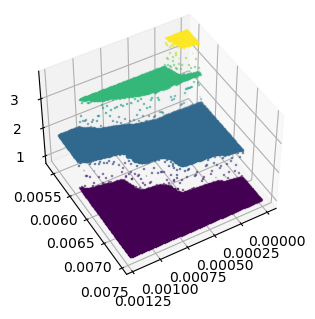

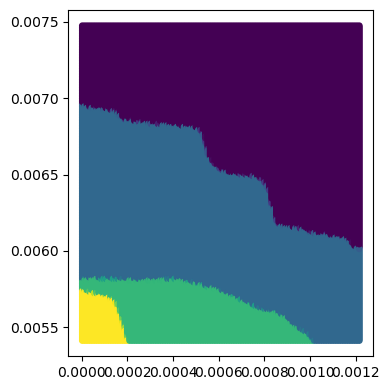

In [17]:
afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_200.xyz')
print(afm)
plot_afm_3d(afm)
plot_afm_2d(afm)

Note - runtime for mean_shift is ~36seconds for this (23600, 3)/~153x153point/200x200 micrograph. ? Scaling for original AFM? Choice of acquisition resolution from instrument - limit to 256x256?

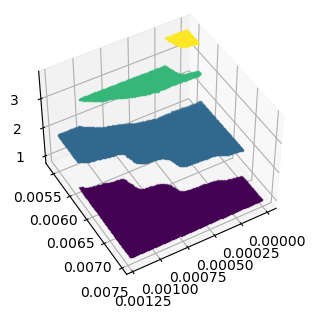

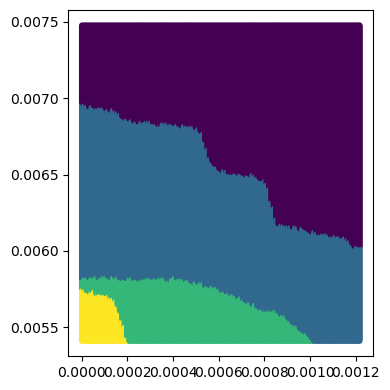

In [18]:
rounded_afm = mean_shift(afm, bandwidth=0.00000475)
plot_afm_3d(rounded_afm)
plot_afm_2d(rounded_afm)

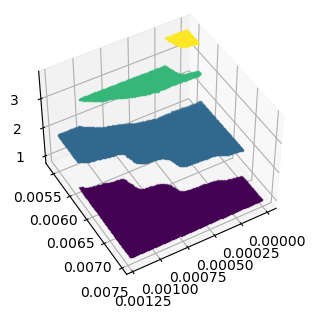

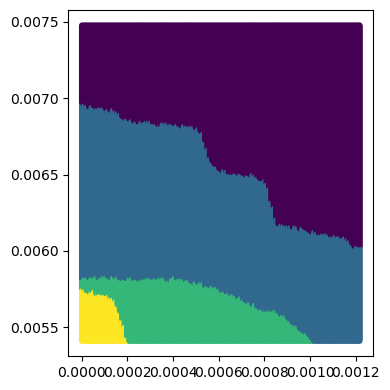

In [19]:
rounded_down_afm = down_shift(afm, bandwidth=0.00000475)
plot_afm_3d(rounded_down_afm)
plot_afm_2d(rounded_down_afm)

In [20]:
original_afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_IDEAL.xyz')
print(original_afm.shape)
print(afm.shape)
print(rounded_afm.shape)

(154624, 3)
(23600, 3)
(23600, 3)


Downsampling time - Need to reduce our point cloud of size (154624, 3) or (23600, 3) -> (1354, 3)

FIrst - NEED to address which terraces belong to which cluster?

In [21]:
unique_z_values = set(point[2] for point in rounded_afm)

print(len(unique_z_values))
print(unique_z_values)

4
{9.290414944757932e-06, 2.7803237622819897e-05, 3.703497693922487e-05, 1.8543724365542377e-05}


In [22]:
# Assigning terraces a label like CG output - ? as to whether needed

"""def assign_terraces(data):
    # Sort the data based on the Z-values
    sorted_data = sorted(data, key=lambda point: point[2])

    # Initialize the label counter and the labeled data
    label_counter = 0
    labeled_data = []

    # Assign labels in ascending order based on Z-values
    current_z_value = None
    for point in sorted_data:
        x, y, z = point
        if z != current_z_value:
            label_counter += 1
            current_z_value = z
        labeled_data.append([label_counter, x, y, z])

    return labeled_data"""

'def assign_terraces(data):\n    # Sort the data based on the Z-values\n    sorted_data = sorted(data, key=lambda point: point[2])\n\n    # Initialize the label counter and the labeled data\n    label_counter = 0\n    labeled_data = []\n\n    # Assign labels in ascending order based on Z-values\n    current_z_value = None\n    for point in sorted_data:\n        x, y, z = point\n        if z != current_z_value:\n            label_counter += 1\n            current_z_value = z\n        labeled_data.append([label_counter, x, y, z])\n\n    return labeled_data'

In [23]:
"""rounded_afm = assign_terraces(rounded_afm)
unique_terraces = set(point[0] for point in rounded_afm)
print(len(unique_terraces))
print(unique_terraces)"""

'rounded_afm = assign_terraces(rounded_afm)\nunique_terraces = set(point[0] for point in rounded_afm)\nprint(len(unique_terraces))\nprint(unique_terraces)'

**2 different methods to try** - Grid Interpolation and t-SNE (t-distributed stochastic neighbor embedding)

**Grid Interpolation** - downsample data in x and y dimensions whilst preserving original z dimension

In [24]:
def interpolate_downsample(afm_data, num_points_xy, method):
    """
    Perform downsampling with interpolation in X and Y dimensions while preserving Z dimension.

    Parameters:
    - afm_data: The input AFM 3D point cloud data as a NumPy array (X, Y, Z).
    - num_points_x: The desired number of points in the X dimension for the structured grid.
    - num_points_y: The desired number of points in the Y dimension for the structured grid.

    Returns:
    - downsampled_afm_data: The downsampled AFM data on the structured grid.
    - interpolated_xyz_point_cloud: The interpolated XYZ point cloud.
    """

    # Separate X, Y, and Z components of the AFM data
    x_points, y_points, z_points = afm_data.T

    # Calculate the min and max values along each axis
    x_min, x_max = min(x_points), max(x_points)
    y_min, y_max = min(y_points), max(y_points)

    # Create a structured grid with downsampling in X and Y
    x_grid, y_grid = np.meshgrid(
        np.linspace(x_min, x_max, num_points_xy),
        np.linspace(y_min, y_max, num_points_xy),
        indexing='ij'
    )

    # Perform interpolation for X and Y dimensions while preserving Z values
    downsampled_afm_data = griddata(
        (x_points, y_points),
        z_points,
        (x_grid, y_grid),
        method=method,
        fill_value=np.nan
    )

    # Convert the structured grid to XYZ point cloud format
    x_interpolated, y_interpolated = x_grid.ravel(), y_grid.ravel()
    z_interpolated = downsampled_afm_data.ravel()
    interpolated_xyz_point_cloud = np.column_stack((x_interpolated, y_interpolated, z_interpolated))

    return interpolated_xyz_point_cloud

using **LINEAR** interpolation:

36 {0.0004531710061834172, 0.0011109530746740163, 0.0003839307884475647, 0.0010417128569381639, 0.0003146905707117121, 0.0009724726392023114, 0.00024545035297585956, 0.0009032324214664588, 0.00017621013524000704, 0.0008339922037306063, 0.00010696991750415449, 0.0007647519859947538, 3.772969976830194e-05, 0.0006955117682589012, 0.0006262715505230486, 0.0005570313327871961, 0.0012148134012777952, 0.0004877911150513435, 0.0011455731835419427, 0.00041855089731549096, 0.00107633296580609, 0.0003493106795796384, 0.0010070927480702375, 0.00028007046184378586, 0.0009378525303343851, 0.00021083024410793332, 0.0008686123125985325, 0.00014159002637208077, 0.00079937209486268, 7.234980863622822e-05, 0.0007301318771268274, 3.109590900375666e-06, 0.0006608916593909749, 0.0005916514416551223, 0.0005224112239192698, 0.0011801932924098688}
36 {0.006531911550487657, 0.007297402299265066, 0.0056486529942060305, 0.006414143742983439, 0.00717963449176085, 0.005530885186701813, 0.006296375935479223, 0.00706

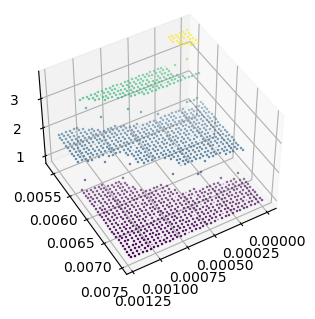

In [25]:
linear = interpolate_downsample(rounded_afm, 36, 'linear')

unique_x_values_linear = set(point[0] for point in linear)
unique_y_values_linear = set(point[1] for point in linear)
unique_z_values_linear = set(point[2] for point in linear)

print(len(unique_x_values_linear), unique_x_values_linear)
print(len(unique_y_values_linear), unique_y_values_linear)
print(len(unique_z_values_linear), unique_z_values_linear)

plot_afm_3d(linear)

using **NEAREST NEIGHBOUR** interpolation:

Method seems most suitable as 36x36x4 grid returned

36 {0.0004531710061834172, 0.0011109530746740163, 0.0003839307884475647, 0.0010417128569381639, 0.0003146905707117121, 0.0009724726392023114, 0.00024545035297585956, 0.0009032324214664588, 0.00017621013524000704, 0.0008339922037306063, 0.00010696991750415449, 0.0007647519859947538, 3.772969976830194e-05, 0.0006955117682589012, 0.0006262715505230486, 0.0005570313327871961, 0.0012148134012777952, 0.0004877911150513435, 0.0011455731835419427, 0.00041855089731549096, 0.00107633296580609, 0.0003493106795796384, 0.0010070927480702375, 0.00028007046184378586, 0.0009378525303343851, 0.00021083024410793332, 0.0008686123125985325, 0.00014159002637208077, 0.00079937209486268, 7.234980863622822e-05, 0.0007301318771268274, 3.109590900375666e-06, 0.0006608916593909749, 0.0005916514416551223, 0.0005224112239192698, 0.0011801932924098688}
36 {0.006531911550487657, 0.007297402299265066, 0.0056486529942060305, 0.006414143742983439, 0.00717963449176085, 0.005530885186701813, 0.006296375935479223, 0.00706

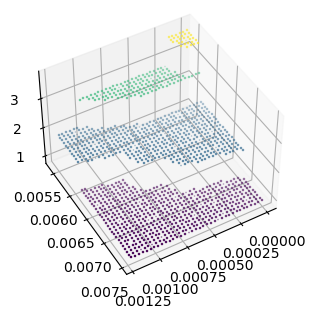

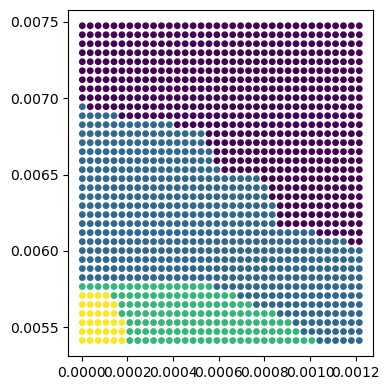

In [30]:
nearest = interpolate_downsample(rounded_afm, 36, 'nearest')

unique_x_values_nearest = set(point[0] for point in nearest)
unique_y_values_nearest = set(point[1] for point in nearest)
unique_z_values_nearest = set(point[2] for point in nearest)

print(len(unique_x_values_nearest), unique_x_values_nearest)
print(len(unique_y_values_nearest), unique_y_values_nearest)
print(len(unique_z_values_nearest), unique_z_values_nearest)

plot_afm_3d(nearest)
plot_afm_2d(nearest)

using **CUBIC SPLINE** interpolation:

36 {0.0004531710061834172, 0.0011109530746740163, 0.0003839307884475647, 0.0010417128569381639, 0.0003146905707117121, 0.0009724726392023114, 0.00024545035297585956, 0.0009032324214664588, 0.00017621013524000704, 0.0008339922037306063, 0.00010696991750415449, 0.0007647519859947538, 3.772969976830194e-05, 0.0006955117682589012, 0.0006262715505230486, 0.0005570313327871961, 0.0012148134012777952, 0.0004877911150513435, 0.0011455731835419427, 0.00041855089731549096, 0.00107633296580609, 0.0003493106795796384, 0.0010070927480702375, 0.00028007046184378586, 0.0009378525303343851, 0.00021083024410793332, 0.0008686123125985325, 0.00014159002637208077, 0.00079937209486268, 7.234980863622822e-05, 0.0007301318771268274, 3.109590900375666e-06, 0.0006608916593909749, 0.0005916514416551223, 0.0005224112239192698, 0.0011801932924098688}
36 {0.006531911550487657, 0.007297402299265066, 0.0056486529942060305, 0.006414143742983439, 0.00717963449176085, 0.005530885186701813, 0.006296375935479223, 0.00706

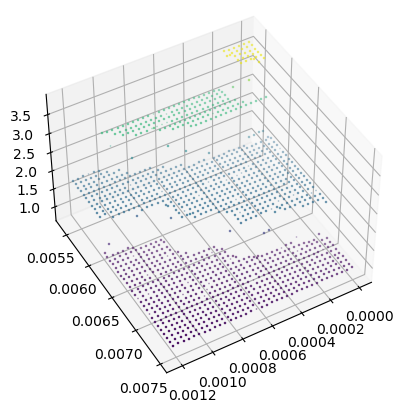

In [27]:
cspline = interpolate_downsample(rounded_afm, 36, 'cubic')

unique_x_values_cspline = set(point[0] for point in cspline)
unique_y_values_cspline = set(point[1] for point in cspline)
unique_z_values_cspline = set(point[2] for point in cspline)

print(len(unique_x_values_cspline), unique_x_values_cspline)
print(len(unique_y_values_cspline), unique_y_values_cspline)
print(len(unique_z_values_cspline), unique_z_values_cspline)

plot_afm_3d(cspline)

### Ripser/TDA on downsampled AFM point cloud

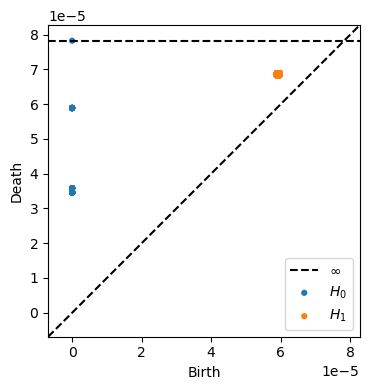

In [28]:
dgms = ripser(nearest)['dgms']
plot_diagrams(dgms, show=True)